In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [3]:
from itertools import chain

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

D:\anaconda\envs\py4dpln\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\anaconda\envs\py4dpln\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [4]:
nltk.corpus.conll2002.fileids()

['esp.testa', 'esp.testb', 'esp.train', 'ned.testa', 'ned.testb', 'ned.train']

In [5]:
%%time
train_sents = list(nltk.corpus.conll2002.iob_sents('esp.train'))
test_sents = list(nltk.corpus.conll2002.iob_sents('esp.testb'))

Wall time: 2.47 s


In [6]:
train_sents[0]

[('Melbourne', 'NP', 'B-LOC'),
 ('(', 'Fpa', 'O'),
 ('Australia', 'NP', 'B-LOC'),
 (')', 'Fpt', 'O'),
 (',', 'Fc', 'O'),
 ('25', 'Z', 'O'),
 ('may', 'NC', 'O'),
 ('(', 'Fpa', 'O'),
 ('EFE', 'NC', 'B-ORG'),
 (')', 'Fpt', 'O'),
 ('.', 'Fp', 'O')]

In [8]:
def word2features(sent,i):
    word = sent[i][0]
    postag = sent[i][1]
    features = {
       ' bias': 1.0 ,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features

In [13]:
def sent2features(sent):
    return [word2features(sent,i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag,label in sent]
def sent2tokens(sent):
    return [token for token,postag,label in sent]

In [14]:
sent2features(train_sents[0])[0]

{' bias': 1.0,
 '+1:postag': 'Fpa',
 '+1:postag[:2]': 'Fp',
 '+1:word.istitle()': False,
 '+1:word.isupper()': False,
 '+1:word.lower()': '(',
 'BOS': True,
 'postag': 'NP',
 'postag[:2]': 'NP',
 'word.isdigit()': False,
 'word.istitle()': True,
 'word.isupper()': False,
 'word.lower()': 'melbourne',
 'word[-2:]': 'ne',
 'word[-3:]': 'rne'}

In [15]:
X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

In [16]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

Wall time: 33.8 s


In [17]:
print(X_train[0:3])
print('............................')
print(y_train[0:3])

[[{'BOS': True, 'word[-2:]': 'ne', '+1:word.istitle()': False, 'word.isdigit()': False, 'word[-3:]': 'rne', '+1:word.lower()': '(', '+1:postag': 'Fpa', '+1:postag[:2]': 'Fp', '+1:word.isupper()': False, 'word.lower()': 'melbourne', ' bias': 1.0, 'postag': 'NP', 'word.isupper()': False, 'postag[:2]': 'NP', 'word.istitle()': True}, {'word[-2:]': '(', '+1:word.istitle()': True, 'word.isdigit()': False, 'word[-3:]': '(', '+1:postag[:2]': 'NP', '-1:postag': 'NP', '+1:postag': 'NP', '+1:word.lower()': 'australia', '+1:word.isupper()': False, 'word.lower()': '(', '-1:word.isupper()': False, '-1:word.lower()': 'melbourne', '-1:postag[:2]': 'NP', '-1:word.istitle()': True, ' bias': 1.0, 'postag': 'Fpa', 'word.isupper()': False, 'postag[:2]': 'Fp', 'word.istitle()': False}, {'word[-2:]': 'ia', '+1:word.istitle()': False, 'word.isdigit()': False, 'word[-3:]': 'lia', '+1:postag[:2]': 'Fp', '-1:postag': 'Fpa', '+1:postag': 'Fpt', '+1:word.lower()': ')', '+1:word.isupper()': False, 'word.lower()': '


............................
[['B-LOC', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O'], ['O'], ['O', 'B-PER', 'I-PER', 'I-PER', 'I-PER', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O']]


In [18]:
labels = list(crf.classes_)
labels.remove('O')
labels

['B-LOC', 'B-ORG', 'B-PER', 'I-PER', 'B-MISC', 'I-ORG', 'I-LOC', 'I-MISC']

In [19]:
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred,
                      average='weighted', labels=labels)

0.7964686316443963

In [20]:
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

             precision    recall  f1-score   support

      B-LOC      0.810     0.784     0.797      1084
      I-LOC      0.690     0.637     0.662       325
     B-MISC      0.731     0.569     0.640       339
     I-MISC      0.699     0.589     0.639       557
      B-ORG      0.807     0.832     0.820      1400
      I-ORG      0.852     0.786     0.818      1104
      B-PER      0.850     0.884     0.867       735
      I-PER      0.893     0.943     0.917       634

avg / total      0.809     0.787     0.796      6178



#超参数调整

In [25]:
%%time
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 13.7min finished


Wall time: 14min 14s


In [26]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))


best params: {'c1': 0.08947547339335606, 'c2': 0.028183154844722565}
best CV score: 0.74918228495038
model size: 1.41M


Dark blue => 0.715, dark red => 0.7492


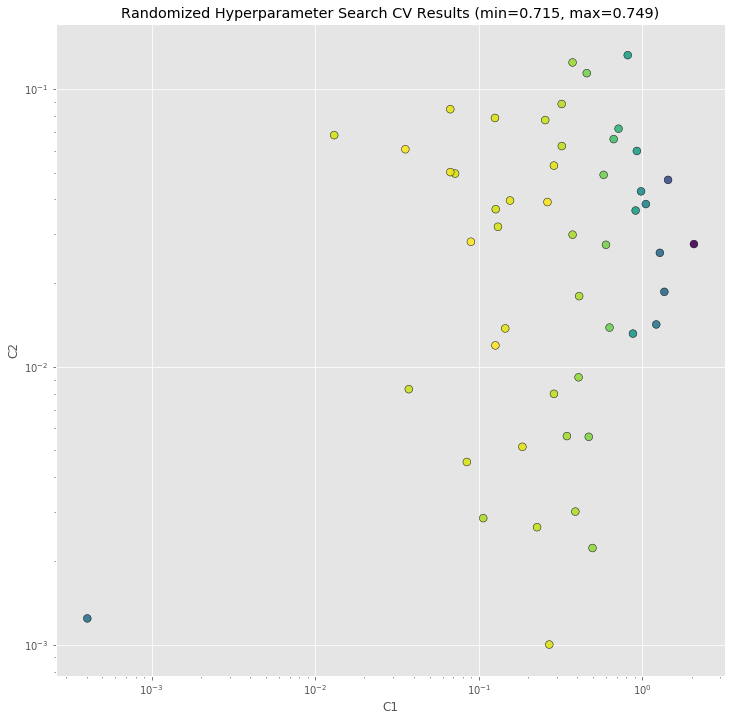

In [27]:
_x = [s.parameters['c1'] for s in rs.grid_scores_]
_y = [s.parameters['c2'] for s in rs.grid_scores_]
_c = [s.mean_validation_score for s in rs.grid_scores_]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))